### ETAのシミュレーション
自動運転車が道路を走る際、

Strategic（運行前計画） => Tactical（運行時の計画） => Ground（細かいセンシングなど）

の3つのフェーズがある。本研究では2つ目のTacticalフェーズにおける、車両の間隔制御を目的とする。まず、Strategicフェーズでは、だいたい何時頃に何台が到着するかがわかる。それを受けてTacticalフェーズでは実際に道路に到着した車に走路の事前予約（以下、CWP Reservation）を行わせ、その通りに運行する。このシミュレーションはCWP Reservationのアルゴリズムについての研究である。

ここでは大きく3つのオブジェクトが登場する

1. CWPTable: 予約管理をするテーブル
2. Car: 到着時刻に基づきCWPTableに希望時刻を打刻する。
3. Simulation: 帯域密度や到着間隔の管理を行う。

In [1]:
import random
import sys
sys.path.append("../../../")
from simulation_classes.eta.car import Cars
from simulation_classes.eta.CWPTable import CWPTable

In [2]:
# 初期設定（独立変数群）
CAR_NUM = 4 #時間窓内の車の総数
START_TIME = 0
GLOBAL_TIME_WINDOW = 10 # Strategic Phaseでの時間幅
TOTAL_LENGTH = 2000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
SCALE_FACTOR = 20 #シミュレーション上で距離を変換するための係数
TIME_STEP = 1
TOTAL_TIME = 1000

# 従属的に決まるもの
SIMULATION_STEPS = int(TOTAL_TIME / TIME_STEP)
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]

arrival_times = sorted([random.uniform(0, GLOBAL_TIME_WINDOW) for _ in range(CAR_NUM)])

CARS = [Cars(arrival_time=time, index=index, mean_speed=MEAN_SPEED) for index, time in enumerate(arrival_times)]
# for i in range(CAR_NUM):
    

In [3]:
# 一旦雑にsimulation開始
cwp_table = CWPTable(waypoints = WAYPOINTS)

for i in range(SIMULATION_STEPS):
    t = i * TIME_STEP

    for car in CARS:
        # この時間に到着する車がいれば打刻する
        if car.arrival_time >= t and car.arrival_time < t + TIME_STEP:
            desired_list = car.create_desired_list(WAYPOINTS)
            # print(desired_list)
            is_valid = cwp_table.validate(desired_list)
            print(is_valid)
            if is_valid:
                cwp_table.register(desired_list)
            else:
                calibrated_list = cwp_table.calibrate_list(desired_list)
                cwp_table.register(calibrated_list)
            continue
        
        # そうでない車は普通に進む
        car.proceed(time_step=TIME_STEP)
            
                




初回
True
False
False
False


In [4]:
df = cwp_table.waypoint_table
print(df[df['car_idx'] == 0])
print(df[df['car_idx'] == 1])
print(CARS[1].arrival_time)

    waypoint_idx       x         eta  car_idx
0              0     0.0    2.393039        0
1              1   200.0   12.393039        0
2              2   400.0   22.393039        0
3              3   600.0   32.393039        0
4              4   800.0   42.393039        0
5              5  1000.0   52.393039        0
6              6  1200.0   62.393039        0
7              7  1400.0   72.393039        0
8              8  1600.0   82.393039        0
9              9  1800.0   92.393039        0
10            10  2000.0  102.393039        0
    waypoint_idx       x         eta  car_idx
0              0     0.0    2.881870        1
1              1   200.0   15.393039        1
2              2   400.0   25.393039        1
3              3   600.0   35.393039        1
4              4   800.0   45.393039        1
5              5  1000.0   55.393039        1
6              6  1200.0   65.393039        1
7              7  1400.0   75.393039        1
8              8  1600.0   85.3930

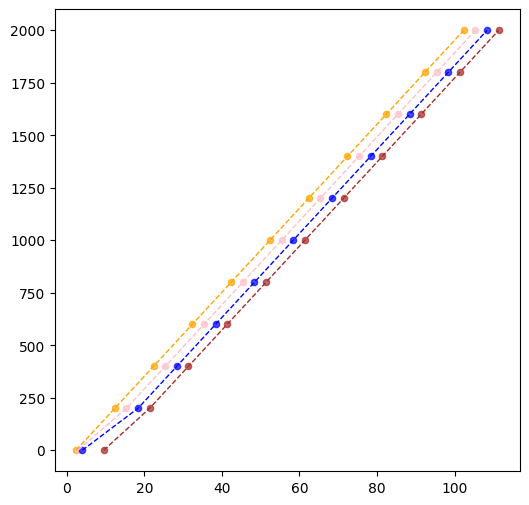

In [5]:
cwp_table.plot()